# Importing Libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from keras.layers import Dense, RNN, LSTM, GRU, SimpleRNN, Dropout, Bidirectional

# Import Plotting Libararies
import seaborn as sns
import matplotlib.pyplot as plt

# Model Evaluation Libraries
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Reading the Dataset and view classes

In [8]:
df = pd.read_csv("/urdu-sentiment-corpus-v1.tsv", delimiter="\t", encoding="utf-8")

In [9]:

df.Class.value_counts()

,count
Class,
N,499
P,480
O,20


In [10]:
df = df[df['Class'] != 'O']

In [11]:

df.head()

,Tweet,Class
0,میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...,P
1,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,N
3,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",P
4,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,P
5,گندی زبان اور گٹر جیسے دماغ والے جاهل جیالے ه...,N


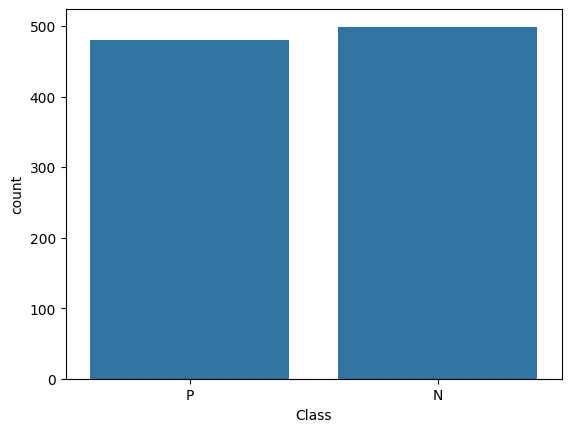

In [13]:
sns.countplot( x = 'Class', data = df );

# Preprocessing the dataset

In [14]:
!pip install urduhack

INFO: pip is looking at multiple versions of tf2crf to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tf2crf to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.0/98.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: Click
    Found existing installation: click 8.3.1
    Uninstalling click-8.3.1:
      Successfully uninstalled click-8.3.1
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorfl

In [15]:
import urduhack
urduhack.download()
from urduhack.normalization import normalize
from urduhack.preprocessing import normalize_whitespace, remove_punctuation, remove_accents, replace_urls, replace_emails, replace_numbers, replace_currency_symbols, remove_english_alphabets


36788015/36788015 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
df['Tweet_cleaned'] = df['Tweet'].apply(normalize) # To normalize some text, all you need to do pass unicode text. It will return a str with normalized characters both single and combined, proper spaces after digits and punctuations and diacritics(Zabar - Paish) removed.
df['Tweet_cleaned'] = df['Tweet_cleaned'].apply(remove_punctuation) # Remove punctuation from text by removing all instances of marks. marks=',;:'
df['Tweet_cleaned'] = df['Tweet_cleaned'].apply(remove_accents) # Remove accents from any accented unicode characters in text str, either by transforming them into ascii equivalents or removing them entirely.
df['Tweet_cleaned'] = df['Tweet_cleaned'].apply(replace_urls) # Replace all URLs in text str with replace_with str.
df['Tweet_cleaned'] = df['Tweet_cleaned'].apply(replace_emails) # Replace all emails in text str with replace_with str.
df['Tweet_cleaned'] = df['Tweet_cleaned'].apply(replace_numbers) # Replace all numbers in text str with replace_with str.
df['Tweet_cleaned'] = df['Tweet_cleaned'].apply(replace_currency_symbols) # Replace all currency symbols in text str with string specified by replace_with str.
df['Tweet_cleaned'] = df['Tweet_cleaned'].apply(remove_english_alphabets) # Removes English words and digits from a text
df['Tweet_cleaned'] = df['Tweet_cleaned'].apply(normalize_whitespace) ## Given text str, replace one or more spacings with a single space, and one or more linebreaks with a single newline. Also strip leading/trailing whitespace.

In [17]:
df.head()

,Tweet,Class,Tweet_cleaned
0,میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...,P,میں نے ایٹم بم بنایا ھے او بھائی ایٹم بمب کوٹ ...
1,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,N,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...
3,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",P,سرچ انجن گوگل کے نائب صدر نے فضا میں فٹ کی بلن...
4,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,P,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار أ
5,گندی زبان اور گٹر جیسے دماغ والے جاهل جیالے ه...,N,گندی زبان اور گٹر جیسے دماغ والے جاہل جیالے ہو...


In [18]:
# Remove stop words from text
from typing import FrozenSet

# Urdu Language Stop words list
STOP_WORDS: FrozenSet[str] = frozenset("""
 آ آئی آئیں آئے آتا آتی آتے آس آمدید آنا آنسہ آنی آنے آپ آگے آہ آہا آیا اب ابھی ابے
 ارے اس اسکا اسکی اسکے اسی اسے اف افوہ البتہ الف ان اندر انکا انکی انکے انہوں انہی انہیں اوئے اور اوپر
 اوہو اپ اپنا اپنوں اپنی اپنے اپنےآپ اکثر اگر اگرچہ اہاہا ایسا ایسی ایسے ایک بائیں بار بارے بالکل باوجود باہر
 بج بجے بخیر بشرطیکہ بعد بعض بغیر بلکہ بن بنا بناؤ بند بڑی بھر بھریں بھی بہت بہتر تاکہ تاہم تب تجھ
 تجھی تجھے ترا تری تلک تم تمام تمہارا تمہاروں تمہاری تمہارے تمہیں تو تک تھا تھی تھیں تھے تیرا تیری تیرے
 جا جاؤ جائیں جائے جاتا جاتی جاتے جانی جانے جب جبکہ جدھر جس جسے جن جناب جنہوں جنہیں جو جہاں جی جیسا
 جیسوں جیسی جیسے حالانکہ حالاں حصہ حضرت خاطر خالی خواہ خوب خود دائیں درمیان دریں دو دوران دوسرا دوسروں دوسری دوں
 دکھائیں دی دیئے دیا دیتا دیتی دیتے دیر دینا دینی دینے دیکھو دیں دیے دے ذریعے رکھا رکھتا رکھتی رکھتے رکھنا رکھنی
 رکھنے رکھو رکھی رکھے رہ رہا رہتا رہتی رہتے رہنا رہنی رہنے رہو رہی رہیں رہے ساتھ سامنے ساڑھے سب سبھی
 سراسر سمیت سوا سوائے سکا سکتا سکتے سہ سہی سی سے شاید شکریہ صاحب صاحبہ صرف ضرور طرح طرف طور علاوہ عین
 فقط فلاں فی قبل قطا لئے لائی لائے لاتا لاتی لاتے لانا لانی لانے لایا لو لوجی لوگوں لگ لگا لگتا
 لگتی لگی لگیں لگے لہذا لی لیا لیتا لیتی لیتے لیکن لیں لیے لے ماسوا مت مجھ مجھی مجھے محترم محترمہ محض
 مرا مرحبا مری مرے مزید مس میں مسز مسٹر مطابق مل مکرمی مگر مگھر مہربانی میرا میروں میری میرے میں نا نزدیک
 نما نہ نہیں نیز نیچے نے و وار واسطے واقعی والا والوں والی والے واہ وجہ ورنہ وغیرہ ولے وگرنہ وہ وہاں
 وہی وہیں ویسا ویسے ویں پاس پایا پر پس پلیز پون پونی پونے پھر پہ پہلا پہلی پہلے پیر پیچھے چاہئے
 چاہتے چاہیئے چاہے چلا چلو چلیں چلے چناچہ چند چونکہ چکی چکیں چکے ڈالنا ڈالنی ڈالنے ڈالے کئے کا کاش کب کبھی
 کدھر کر کرتا کرتی کرتے کرم کرنا کرنے کرو کریں کرے کس کسی کسے کم کن کنہیں کو کوئی کون کونسا
 کونسے کچھ کہ کہا کہاں کہہ کہی کہیں کہے کی کیا کیسا کیسے کیونکر کیونکہ کیوں کیے کے گئی گئے گا گنا
 گو گویا گی گیا ہائیں ہائے ہاں ہر ہرچند ہرگز ہم ہمارا ہماری ہمارے ہمی ہمیں ہو ہوئی ہوئیں ہوئے ہوا
 ہوبہو ہوتا ہوتی ہوتیں ہوتے ہونا ہونگے ہونی ہونے ہوں ہی ہیلو ہیں ہے یا یات یعنی یک یہ یہاں یہی یہیں
""".split())


def remove_stopwords(text: str):
    return " ".join(word for word in text.split(", ") if word not in STOP_WORDS)


In [19]:
df['Tweet_WO_stopWords'] = df['Tweet_cleaned'].apply(remove_stopwords)

In [20]:
import re
import nltk

def word_tokenized(text):
    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
    return text


In [21]:
df['Tweet_cleaned_tokenized'] =  df['Tweet_WO_stopWords'].apply(word_tokenized)

In [22]:
df.head()

,Tweet,Class,Tweet_cleaned,Tweet_WO_stopWords,Tweet_cleaned_tokenized
0,میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...,P,میں نے ایٹم بم بنایا ھے او بھائی ایٹم بمب کوٹ ...,میں نے ایٹم بم بنایا ھے او بھائی ایٹم بمب کوٹ ...,"[میں, نے, ایٹم, بم, بنایا, ھے, او, بھائی, ایٹم..."
1,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,N,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,"[چندے, سے, انقلاب, اور, عمران, خان, وزیر, اعظم..."
3,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",P,سرچ انجن گوگل کے نائب صدر نے فضا میں فٹ کی بلن...,سرچ انجن گوگل کے نائب صدر نے فضا میں فٹ کی بلن...,"[سرچ, انجن, گوگل, کے, نائب, صدر, نے, فضا, میں,..."
4,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,P,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار أ,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار أ,"[ابھی, تک, اسکی, لہریں, کبھی, کبھی, آ, جاتی, ہ..."
5,گندی زبان اور گٹر جیسے دماغ والے جاهل جیالے ه...,N,گندی زبان اور گٹر جیسے دماغ والے جاہل جیالے ہو...,گندی زبان اور گٹر جیسے دماغ والے جاہل جیالے ہو...,"[گندی, زبان, اور, گٹر, جیسے, دماغ, والے, جاہل,..."


In [23]:
print(df.Tweet_cleaned_tokenized[4])

['ابھی', 'تک', 'اسکی', 'لہریں', 'کبھی', 'کبھی', 'آ', 'جاتی', 'ہیں', 'یار', 'أ']


In [24]:
unique_words = set(word for sublist in df['Tweet_cleaned_tokenized'] for word in sublist)
print(len(unique_words))

4547


In [25]:
num_words = 5000
oov_token = ''
pad_type = 'post'
trunc_type = 'post'


tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(df.Tweet_cleaned_tokenized)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
sequences = tokenizer.texts_to_sequences(df.Tweet_cleaned_tokenized)

# Get max training sequence length
seq_maxlen = max([len(x) for x in sequences])

# Pad the training sequences
seq_pad  = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=seq_maxlen)


# Output the results of our work
print("Word index:\n", word_index)
print("\nTraining sequences:\n", sequences)
print("\nPadded training sequences:\n", seq_pad )
print("\nPadded training shape:", seq_pad.shape)
print("Training sequences data type:", type(sequences))
print("Padded Training sequences data type:", type(seq_pad ))

Word index:
 {'': 1, 'کے': 2, 'کی': 3, 'میں': 4, 'ہے': 5, 'سے': 6, 'کا': 7, 'کو': 8, 'اور': 9, 'نے': 10, 'پر': 11, 'تو': 12, 'نہیں': 13, 'ہیں': 14, 'بھی': 15, 'ہو': 16, 'کر': 17, 'اس': 18, 'کہ': 19, 'کیا': 20, 'پاکستان': 21, 'ھے': 22, 'نہ': 23, 'اللہ': 24, 'یہ': 25, 'وہ': 26, 'ہی': 27, 'گا': 28, 'خان': 29, 'ایک': 30, 'گیا': 31, 'آپ': 32, 'کوئی': 33, 'گے': 34, 'ملک': 35, 'جو': 36, 'انقلاب': 37, 'اب': 38, 'ہم': 39, 'لاہور': 40, 'کرنے': 41, 'ان': 42, 'عمران': 43, 'اپنے': 44, 'ہوں': 45, 'تحریک': 46, 'جائے': 47, 'عمر': 48, 'تھا': 49, 'ڈیزل': 50, 'بات': 51, 'کچھ': 52, 'دیا': 53, 'لیے': 54, 'کسی': 55, 'چندے': 56, 'گئے': 57, 'حکومت': 58, 'آباد': 59, 'بے': 60, 'پی': 61, 'لوگ': 62, 'آج': 63, 'والے': 64, 'تھے': 65, 'اسلام': 66, 'و': 67, 'ٹیسٹ': 68, 'اے': 69, 'بہت': 70, 'اگر': 71, 'گی': 72, 'ایم': 73, 'بن': 74, 'کام': 75, 'جی': 76, 'دل': 77, 'جس': 78, 'دو': 79, 'لئے': 80, 'کراچی': 81, 'اپنی': 82, 'سب': 83, 'ختم': 84, 'مجھے': 85, 'ساتھ': 86, 'بعد': 87, 'قادری': 88, 'جب': 89, 'فاروق': 90, 'کریں': 91

In [26]:
print(seq_maxlen)


35


In [27]:
x_train , X_test = train_test_split(seq_pad, test_size=0.25, random_state=42)

In [28]:
train_data , test_data = train_test_split(df[['Tweet_cleaned_tokenized', 'Class']], test_size=0.25, random_state=42)
print(train_data.shape,"___",test_data.shape)

(735, 2) ___ (245, 2)


In [29]:
labels = ['P', 'N']
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(df.Class.to_list())
y_train = encoder.transform(train_data.Class.to_list())
y_test = encoder.transform(test_data.Class.to_list())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(y_train.shape, "____", y_test.shape)

(735, 1) ____ (245, 1)


# Models Building
We are now building our models after preprocessing the dataset, we will build following models given bellow:

- RNN
- GRU
- LSTM
- BiLSTM

And to build models we have to use the given configurations:

1. 2 Layers with dropout 0.3 and 0.7
2. 3 Layers with dropout 0.3 and 0.7

# RNN

**2 layers with dropout 0.3**

In [30]:
model = Sequential()
model.add(SimpleRNN(32, return_sequences='True', input_shape=(35, 1)))
model.add(SimpleRNN(16))
model.add(Dropout(0.3))
model.add(Dense(1,'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history_RNN = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

test_predictionRNN = model.predict( X_test )
y_prediction = [0 if val < 0.5 else 1 for val in test_predictionRNN]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  RNN \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step - accuracy: 0.5262 - loss: 0.7273 - val_accuracy: 0.5143 - val_loss: 0.7042
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5474 - loss: 0.6879 - val_accuracy: 0.4816 - val_loss: 0.7087
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5308 - loss: 0.6979 - val_accuracy: 0.4980 - val_loss: 0.7033
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6068 - loss: 0.6726 - val_accuracy: 0.4898 - val_loss: 0.7062
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5664 - loss: 0.6746 - val_accuracy: 0.5020 - val_loss: 0.7015
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5708 - loss: 0.6785 - val_accuracy: 0.5265 - val_loss: 0.6920
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5353 - loss: 0.6917 - val_accuracy: 0.5143 - val_loss: 0.6927
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5443 - loss: 0.6880 - val_accuracy: 0.5347 - 

In [31]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5306122448979592      |	 Precision: 0.5181818181818182      |	 Recall: 0.4789915966386555     |	 F-score: 0.4978165938864629 



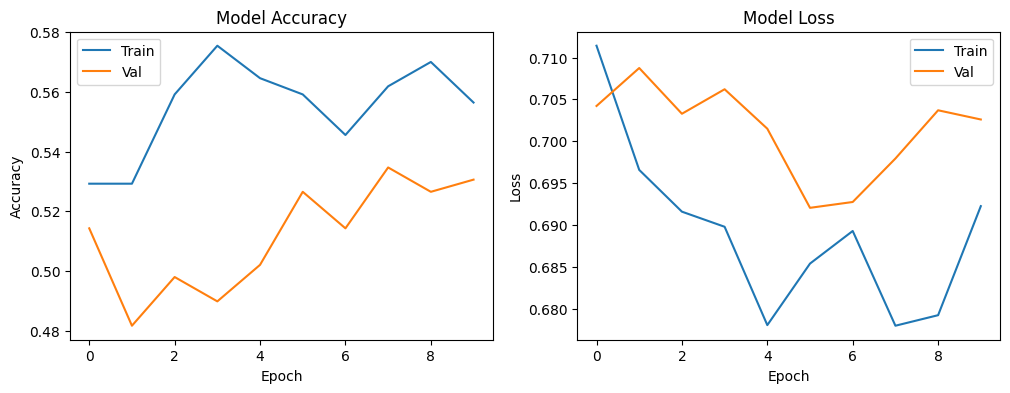

In [32]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_RNN.history['accuracy'])
axes[0].plot(history_RNN.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Val'])

# Plot the second graph on the right axis
axes[1].plot(history_RNN.history['loss'])
axes[1].plot(history_RNN.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Val'])

# Display the plot
plt.show()

# 2 layers with dropout 0.7

In [33]:
############################ RNN ################################
model = Sequential()
model.add(SimpleRNN(32, return_sequences='True', input_shape=(35, 1)))
model.add(SimpleRNN(16))
model.add(Dropout(0.7))
model.add(Dense(1,'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history_RNN = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

test_predictionRNN = model.predict( X_test )
y_prediction = [0 if val < 0.5 else 1 for val in test_predictionRNN]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  RNN \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.5160 - loss: 0.8111 - val_accuracy: 0.5469 - val_loss: 0.6872
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5016 - loss: 0.7758 - val_accuracy: 0.5224 - val_loss: 0.6953
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5493 - loss: 0.7535 - val_accuracy: 0.5306 - val_loss: 0.6982
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5491 - loss: 0.7260 - val_accuracy: 0.5306 - val_loss: 0.6972
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4834 - loss: 0.7427 - val_accuracy: 0.5592 - val_loss: 0.6890
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5214 - loss: 0.7146 - val_accuracy: 0.5469 - val_loss: 0.6915
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5760 - loss: 0.7054 - val_accuracy: 0.5388 - val_loss: 0.6893
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5417 - loss: 0.7143 - val_accuracy: 0.5592 -

In [34]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5306122448979592      |	 Precision: 0.515625      |	 Recall: 0.5546218487394958     |	 F-score: 0.5344129554655871 



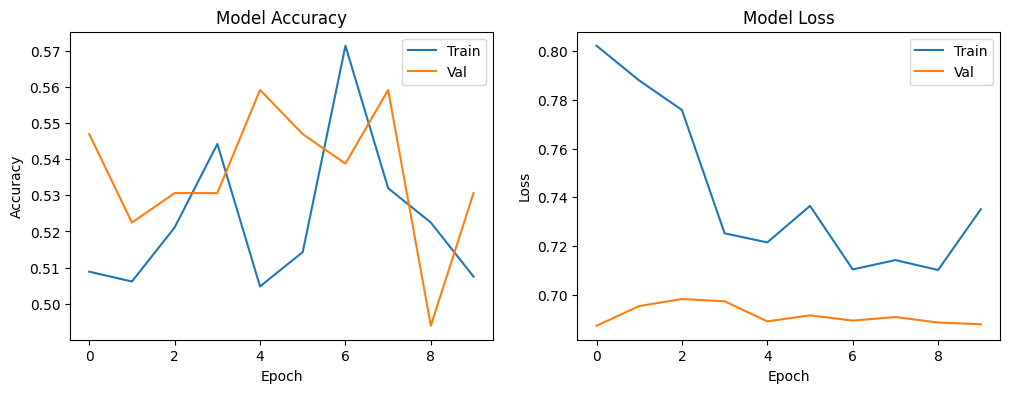

In [35]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_RNN.history['accuracy'])
axes[0].plot(history_RNN.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Val'])

# Plot the second graph on the right axis
axes[1].plot(history_RNN.history['loss'])
axes[1].plot(history_RNN.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Val'])

# Display the plot
plt.show()

# 3 layers with dropout 0.3

In [36]:
model = Sequential()
model.add(SimpleRNN(32, return_sequences='True', input_shape=(35, 1)))
model.add(SimpleRNN(32, return_sequences='True'))
model.add(SimpleRNN(16))
model.add(Dropout(0.3))
model.add(Dense(1,'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history_RNN = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

test_predictionRNN = model.predict( X_test )

y_prediction = [0 if val < 0.5 else 1 for val in test_predictionRNN]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  RNN \n')
print(class_report)
print(conf_matrix)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 464ms/step - accuracy: 0.5107 - loss: 0.7511 - val_accuracy: 0.5265 - val_loss: 0.7083
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5412 - loss: 0.7007 - val_accuracy: 0.5429 - val_loss: 0.7114
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5533 - loss: 0.6951 - val_accuracy: 0.5102 - val_loss: 0.7098
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5805 - loss: 0.6835 - val_accuracy: 0.4980 - val_loss: 0.7116
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5724 - loss: 0.6821 - val_accuracy: 0.5265 - val_loss: 0.7025
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5603 - loss: 0.6851 - val_accuracy: 0.5020 - val_loss: 0.7107
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5481 - loss: 0.6872 - val_accuracy: 0.5143 - val_loss: 0.7044
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5798 - loss: 0.6801 - val_accuracy: 0.5265 - val_loss: 

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step
Results of  RNN 

              precision    recall  f1-score   support

           0       0.46      0.48      0.47       122
           1       0.46      0.45      0.45       123

    accuracy                           0.46       245
   macro avg       0.46      0.46      0.46       245
weighted avg       0.46      0.46      0.46       245

[[58 64]
 [68 55]]


In [37]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")



							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.46122448979591835      |	 Precision: 0.44715447154471544      |	 Recall: 0.46218487394957986     |	 F-score: 0.45454545454545453 



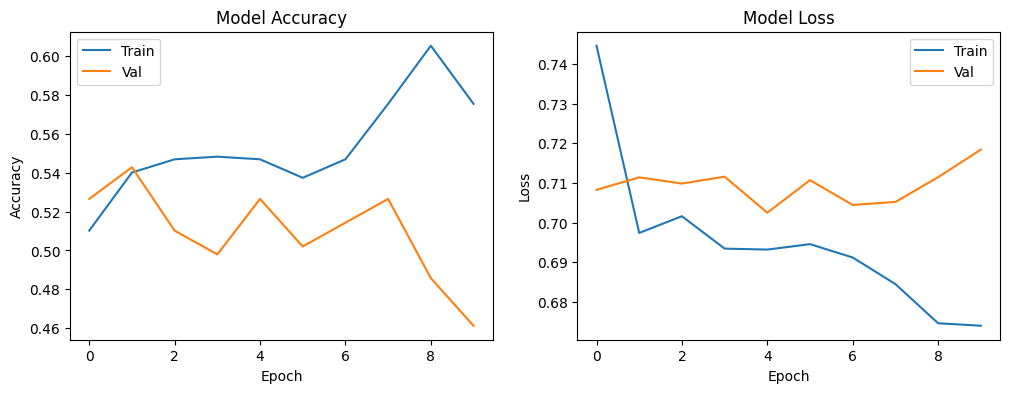

In [38]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_RNN.history['accuracy'])
axes[0].plot(history_RNN.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Val'])

# Plot the second graph on the right axis
axes[1].plot(history_RNN.history['loss'])
axes[1].plot(history_RNN.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Val'])

# Display the plot
plt.show()

# 3 layers with dropout 0.7

In [39]:
model = Sequential()
model.add(SimpleRNN(32, return_sequences='True', input_shape=(35, 1)))
model.add(SimpleRNN(32, return_sequences='True'))
model.add(SimpleRNN(16))
model.add(Dropout(0.7))
model.add(Dense(1,'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history_RNN = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

test_predictionRNN = model.predict( X_test )
y_prediction = [0 if val < 0.5 else 1 for val in test_predictionRNN]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  RNN \n')
print(class_report)
print(conf_matrix)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 288ms/step - accuracy: 0.4491 - loss: 0.8798 - val_accuracy: 0.5020 - val_loss: 0.7267
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5169 - loss: 0.8303 - val_accuracy: 0.4776 - val_loss: 0.7289
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5012 - loss: 0.7988 - val_accuracy: 0.4939 - val_loss: 0.7203
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5238 - loss: 0.7664 - val_accuracy: 0.5265 - val_loss: 0.7117
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5009 - loss: 0.7756 - val_accuracy: 0.4857 - val_loss: 0.7233
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5386 - loss: 0.7445 - val_accuracy: 0.4898 - val_loss: 0.7064
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4816 - loss: 0.7880 - val_accuracy: 0.5265 - val_loss: 0.6987
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5016 - loss: 0.7273 - val_accuracy: 0.4898 - val_loss: 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
Results of  RNN 

              precision    recall  f1-score   support

           0       0.52      0.54      0.53       120
           1       0.54      0.51      0.52       125

    accuracy                           0.53       245
   macro avg       0.53      0.53      0.53       245
weighted avg       0.53      0.53      0.53       245

[[65 55]
 [61 64]]


In [40]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5265306122448979      |	 Precision: 0.512      |	 Recall: 0.5378151260504201     |	 F-score: 0.5245901639344263 



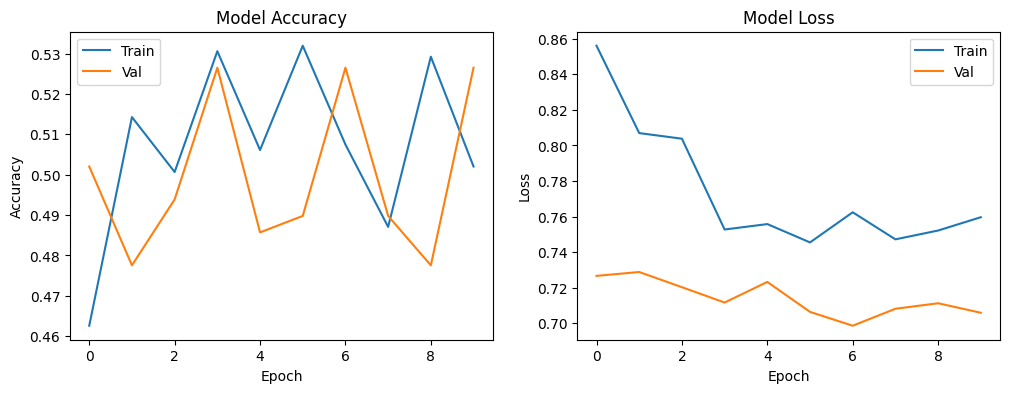

In [41]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_RNN.history['accuracy'])
axes[0].plot(history_RNN.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Val'])

# Plot the second graph on the right axis
axes[1].plot(history_RNN.history['loss'])
axes[1].plot(history_RNN.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Val'])

# Display the plot
plt.show()

#GRU

# 2 layers with dropout 0.3

In [42]:
modelgru = tf.keras.Sequential([
    tf.keras.layers.GRU(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True, input_shape=(35,1)),
    tf.keras.layers.GRU(16, dropout=0.3, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modelgru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru.summary()

history_gru = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictiongru = model.predict(X_test)

y_prediction = [0 if val < 0.5 else 1 for val in test_predictiongru]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  GRU \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 35, 32)         │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,777 (22.57 KB)

 Trainable params: 5,777 (22.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5613 - loss: 0.6919 - val_accuracy: 0.4857 - val_loss: 0.6950
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5496 - loss: 0.6939 - val_accuracy: 0.5224 - val_loss: 0.7096
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5060 - loss: 0.7154 - val_accuracy: 0.4571 - val_loss: 0.7117
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5496 - loss: 0.7005 - val_accuracy: 0.5388 - val_loss: 0.6983
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5170 - loss: 0.7269 - val_accuracy: 0.5265 - val_loss: 0.6945
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Results of  GRU 

              precision    recall  f1-score   support

           0       0.48      0.55      0.51       110
           1       0.58      0.51      0.54       135

    accuracy                           0.53       245
   macro avg       0.53      0.53      0.53       245
weighted avg       0.53      0.53      0.5

In [43]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5265306122448979      |	 Precision: 0.5111111111111111      |	 Recall: 0.5798319327731093     |	 F-score: 0.5433070866141733 



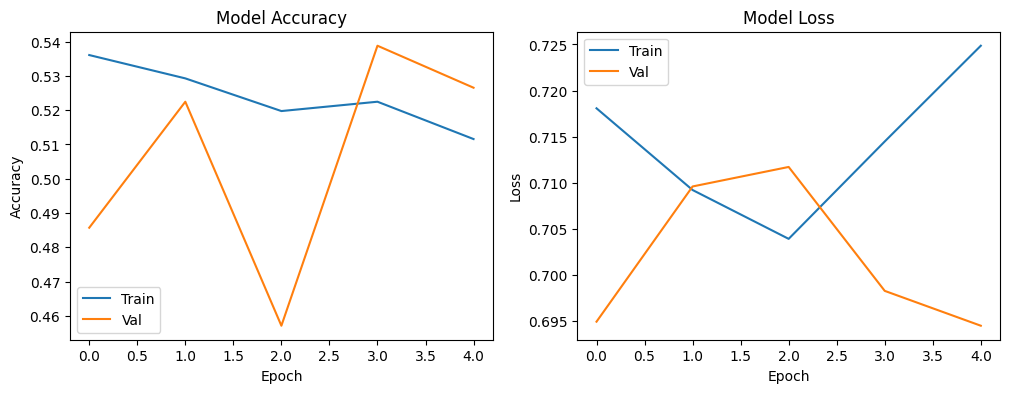

In [44]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_gru.history['accuracy'])
axes[0].plot(history_gru.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Val'])

# Plot the second graph on the right axis
axes[1].plot(history_gru.history['loss'])
axes[1].plot(history_gru.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Val'])

# Display the plot
plt.show()

# 2 layers with dropout 0.7

In [45]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True, input_shape=(35,1)),
    tf.keras.layers.GRU(16, dropout=0.7, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


#rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
modelgru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru.summary()

history_gru = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictiongru = model.predict(X_test)

y_prediction = [0 if val < 0.5 else 1 for val in test_predictiongru]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  GRU \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 35, 32)         │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,777 (22.57 KB)

 Trainable params: 5,777 (22.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5335 - loss: 0.7234 - val_accuracy: 0.5061 - val_loss: 0.7038
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5430 - loss: 0.6991 - val_accuracy: 0.5020 - val_loss: 0.6978
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5531 - loss: 0.6984 - val_accuracy: 0.4816 - val_loss: 0.7026
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5476 - loss: 0.7107 - val_accuracy: 0.5224 - val_loss: 0.7085
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5502 - loss: 0.7122 - val_accuracy: 0.5102 - val_loss: 0.7052
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Results of  GRU 

              precision    recall  f1-score   support

           0       0.64      0.52      0.57       156
           1       0.37      0.49      0.42        89

    accuracy                           0.51       245
   macro avg       0.51      0.51      0.50       245
weighted avg       0.54      0.51      0.5

In [46]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True, input_shape=(35,1)),
    tf.keras.layers.GRU(16, dropout=0.7, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


#rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
modelgru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru.summary()

history_gru = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictiongru = model.predict(X_test)

y_prediction = [0 if val < 0.5 else 1 for val in test_predictiongru]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  GRU \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 35, 32)         │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,777 (22.57 KB)

 Trainable params: 5,777 (22.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5417 - loss: 0.7042 - val_accuracy: 0.5388 - val_loss: 0.7021
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5385 - loss: 0.6970 - val_accuracy: 0.4857 - val_loss: 0.7039
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5568 - loss: 0.6708 - val_accuracy: 0.4816 - val_loss: 0.7053
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5513 - loss: 0.6813 - val_accuracy: 0.4898 - val_loss: 0.7046
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5720 - loss: 0.6922 - val_accuracy: 0.5102 - val_loss: 0.6947
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Results of  GRU 

              precision    recall  f1-score   support

           0       0.52      0.52      0.52       126
           1       0.50      0.50      0.50       119

    accuracy                           0.51       245
   macro avg       0.51      0.51      0.51       245
weighted avg       0.51      0.51      0.5

In [47]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5102040816326531      |	 Precision: 0.4957983193277311      |	 Recall: 0.4957983193277311     |	 F-score: 0.4957983193277311 



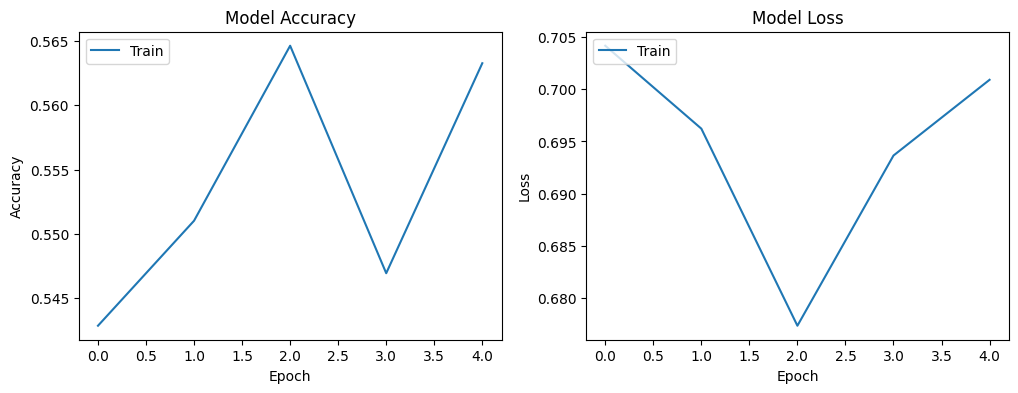

In [48]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_gru.history['accuracy'])
# axes[0].plot(history_gru.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot the second graph on the right axis
axes[1].plot(history_gru.history['loss'])
# axes[1].plot(history_gru.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Test'], loc='upper left')

# Display the plot
plt.show()

# 3 layers with dropout 0.3

In [49]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True, input_shape=(35,1)),
    tf.keras.layers.GRU(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True,),
    tf.keras.layers.GRU(16, dropout=0.3, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


#rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
modelgru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru.summary()

history_gru = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictiongru = model.predict(X_test)

y_prediction = [0 if val < 0.5 else 1 for val in test_predictiongru]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  GRU \n')
print(class_report)
print(conf_matrix)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 35, 32)         │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,777 (22.57 KB)

 Trainable params: 5,777 (22.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5585 - loss: 0.6787 - val_accuracy: 0.5510 - val_loss: 0.6961
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5343 - loss: 0.6961 - val_accuracy: 0.5306 - val_loss: 0.6972
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5522 - loss: 0.6975 - val_accuracy: 0.4898 - val_loss: 0.7009
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5805 - loss: 0.6793 - val_accuracy: 0.5020 - val_loss: 0.7030
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5678 - loss: 0.6779 - val_accuracy: 0.5061 - val_loss: 0.7096
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Results of  GRU 

              precision    recall  f1-score   support

           0       0.64      0.52      0.57       157
           1       0.36      0.49      0.42        88

    accuracy                           0.51       245
   macro avg       0.50      0.50      0.49       245
weighted avg       0.54      0.51      0.5

In [50]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5061224489795918      |	 Precision: 0.48863636363636365      |	 Recall: 0.36134453781512604     |	 F-score: 0.41545893719806765 



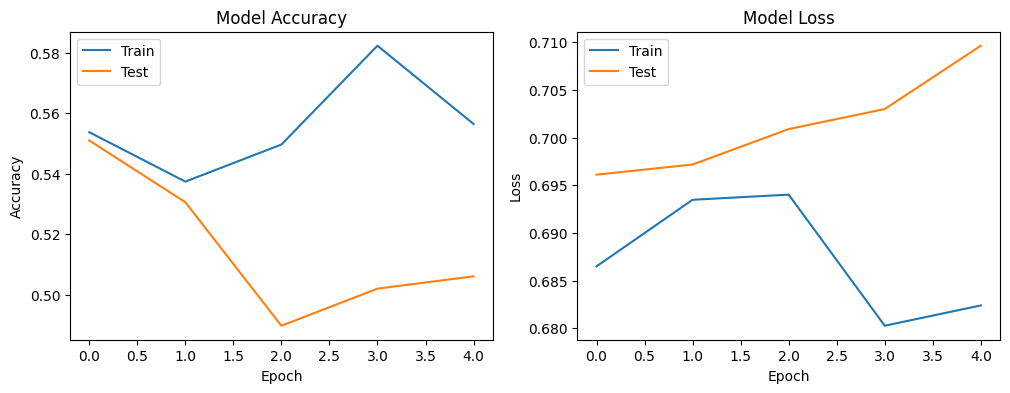

In [51]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_gru.history['accuracy'])
axes[0].plot(history_gru.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot the second graph on the right axis
axes[1].plot(history_gru.history['loss'])
axes[1].plot(history_gru.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Test'], loc='upper left')

# Display the plot
plt.show()

# 3 layers with dropout 0.7

In [54]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True, input_shape=(35,1)),
    tf.keras.layers.GRU(32, dropout=0.7, recurrent_dropout=0.2, return_sequences=True,),
    tf.keras.layers.GRU(16, dropout=0.7, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


#rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
modelgru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru.summary()

history_gru = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictiongru = model.predict(X_test)

y_prediction = [0 if val < 0.5 else 1 for val in test_predictiongru]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  GRU \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 35, 32)         │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,777 (22.57 KB)

 Trainable params: 5,777 (22.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5721 - loss: 0.6891 - val_accuracy: 0.5020 - val_loss: 0.7112
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5493 - loss: 0.6940 - val_accuracy: 0.4653 - val_loss: 0.7012
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5881 - loss: 0.6671 - val_accuracy: 0.4612 - val_loss: 0.7057
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5482 - loss: 0.6763 - val_accuracy: 0.4735 - val_loss: 0.7062
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6078 - loss: 0.6538 - val_accuracy: 0.5224 - val_loss: 0.7091
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Results of  GRU 

              precision    recall  f1-score   support

           0       0.44      0.54      0.49       103
           1       0.61      0.51      0.55       142

    accuracy                           0.52       245
   macro avg       0.52      0.53      0.52       245
weighted avg       0.54      0.52      0.5

In [55]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5224489795918368      |	 Precision: 0.5070422535211268      |	 Recall: 0.6050420168067226     |	 F-score: 0.5517241379310345 



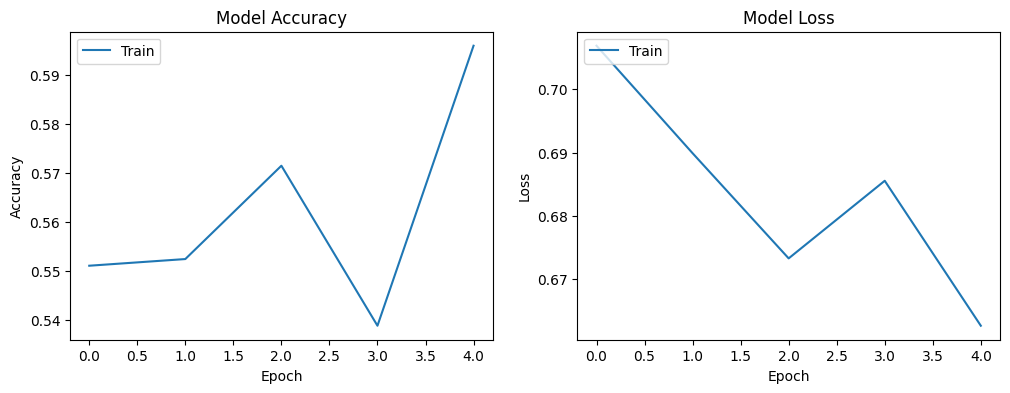

In [56]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_gru.history['accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot the second graph on the right axis
axes[1].plot(history_gru.history['loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Test'], loc='upper left')

# Display the plot
plt.show()

# LSTM
# 2 layers with dropout 0.3

In [58]:
##################################### LSTM ###############################################3
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True, input_shape=(35,1)),
    tf.keras.layers.LSTM(16, dropout=0.3, recurrent_dropout=0.2), # Changed return_sequences=True to False (or removed it)
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictionlstm = model_lstm.predict( X_test ) # Changed from 'model' to 'model_lstm'

y_prediction = [0 if val < 0.5 else 1 for val in test_predictionlstm]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  LSTM \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 35, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,505 (29.32 KB)

 Trainable params: 7,505 (29.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step - accuracy: 0.4566 - loss: 0.7152 - val_accuracy: 0.4653 - val_loss: 0.6965
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.5092 - loss: 0.6964 - val_accuracy: 0.5102 - val_loss: 0.6902
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.4809 - loss: 0.7023 - val_accuracy: 0.4776 - val_loss: 0.6926
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - accuracy: 0.5311 - loss: 0.6910 - val_accuracy: 0.4939 - val_loss: 0.6918
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.5233 - loss: 0.6950 - val_accuracy: 0.5143 - val_loss: 0.6898
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
Results of  LSTM 

              precision    recall  f1-score   support

           0       0.94      0.52      0.67       231
           1       0.06      0.50      0.11        14

    accuracy                           0.51       245
   macro avg       0.50      0.51      0.39       245
weighted avg       0.89      0.51 

In [59]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")



							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5142857142857142      |	 Precision: 0.5      |	 Recall: 0.058823529411764705     |	 F-score: 0.10526315789473684 



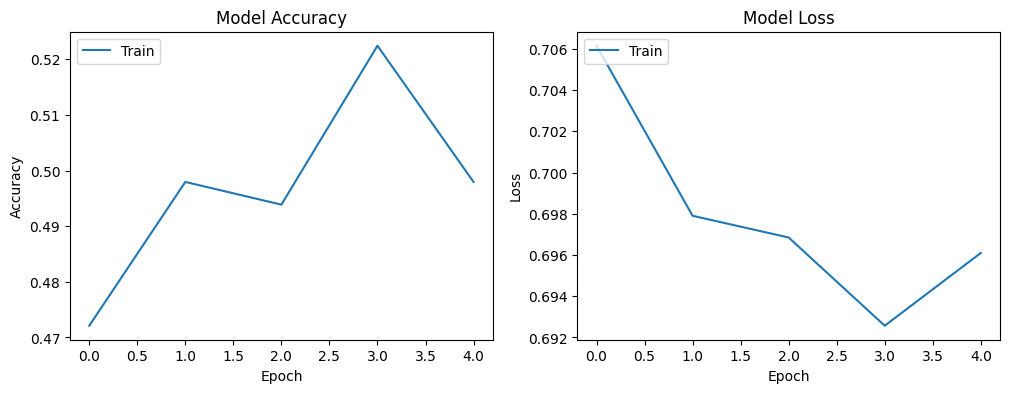

In [60]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_lstm.history['accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot the second graph on the right axis
axes[1].plot(history_lstm.history['loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Test'], loc='upper left')

# Display the plot
plt.show()

# 2 layers with dropout 0.7

In [69]:
##################################### LSTM ###############################################3
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, dropout=0.7, recurrent_dropout=0.2, return_sequences=True, input_shape=(35,1)),
    tf.keras.layers.LSTM(16, dropout=0.7, recurrent_dropout=0.2), # Changed return_sequences=True to False (or removed it)
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictionlstm = model_lstm.predict( X_test )

y_prediction = [0 if val < 0.5 else 1 for val in test_predictionlstm]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  LSTM \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 35, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,505 (29.32 KB)

 Trainable params: 7,505 (29.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.4773 - loss: 0.6943 - val_accuracy: 0.5184 - val_loss: 0.6850
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4546 - loss: 0.6957 - val_accuracy: 0.5224 - val_loss: 0.6848
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - accuracy: 0.5056 - loss: 0.6993 - val_accuracy: 0.5184 - val_loss: 0.6852
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.4313 - loss: 0.6997 - val_accuracy: 0.5143 - val_loss: 0.6863
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step - accuracy: 0.4968 - loss: 0.6958 - val_accuracy: 0.5143 - val_loss: 0.6880
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step
Results of  LSTM 

              precision    recall  f1-score   support

           0       1.00      0.51      0.68       245
           1       0.00      0.00      0.00         0

    accuracy                           0.51       245
   macro avg       0.50      0.26      0.34       245
weighted avg       1.00      0.51  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")



							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5142857142857142      |	 Precision: 0.0      |	 Recall: 0.0     |	 F-score: 0.0 



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


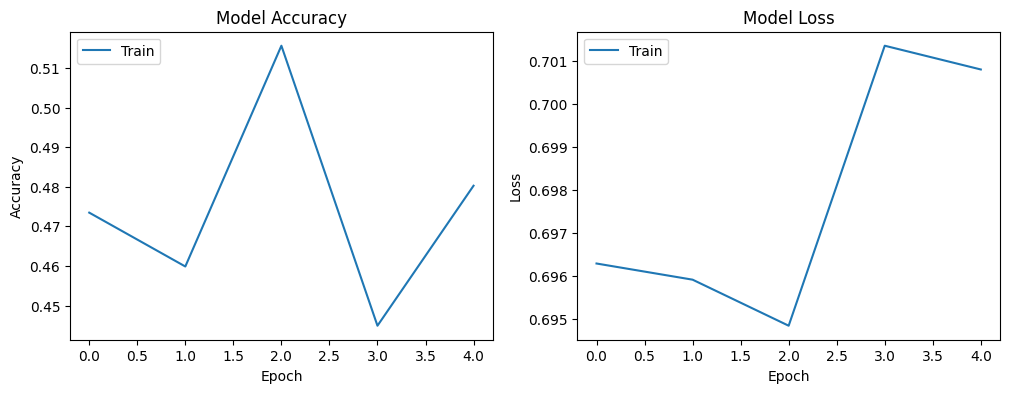

In [71]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_lstm.history['accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot the second graph on the right axis
axes[1].plot(history_lstm.history['loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Test'], loc='upper left')

# Display the plot
plt.show()

# 3 layers with dropout 0.3

In [73]:
##################################### LSTM ###############################################3
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True, input_shape=(35,1)),
    tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(16, dropout=0.3, recurrent_dropout=0.2, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictionlstm = model_lstm.predict( X_test )
y_prediction = [0 if val < 0.5 else 1 for val in test_predictionlstm]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  LSTM \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 35, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 35, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,825 (61.82 KB)

 Trainable params: 15,825 (61.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - accuracy: 0.4844 - loss: 0.6965 - val_accuracy: 0.5224 - val_loss: 0.6916
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 460ms/step - accuracy: 0.4969 - loss: 0.6963 - val_accuracy: 0.5306 - val_loss: 0.6910
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accuracy: 0.5035 - loss: 0.6966 - val_accuracy: 0.5429 - val_loss: 0.6921
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step - accuracy: 0.5157 - loss: 0.6923 - val_accuracy: 0.6082 - val_loss: 0.6900
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 379ms/step - accuracy: 0.5040 - loss: 0.6939 - val_accuracy: 0.5388 - val_loss: 0.6887
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step
Results of  LSTM 

              precision    recall  f1-score   support

           0       0.91      0.53      0.67       217
           1       0.14      0.61      0.23        28

    accuracy                           0.54       245
   macro avg       0.53      0.57      0.45       245
weighted avg       0.82      0.54 

In [74]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5387755102040817      |	 Precision: 0.6071428571428571      |	 Recall: 0.14285714285714285     |	 F-score: 0.23129251700680273 



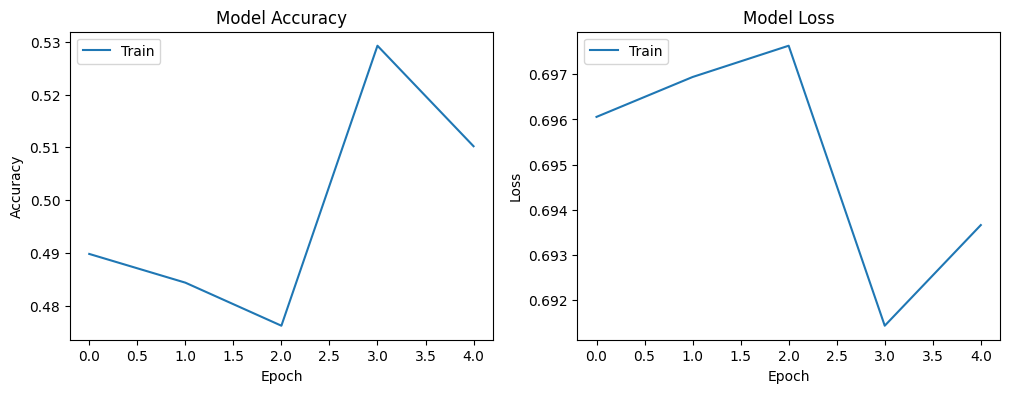

In [75]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_lstm.history['accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot the second graph on the right axis
axes[1].plot(history_lstm.history['loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Test'], loc='upper left')

# Display the plot
plt.show()

# 3 layers with dropout 0.7

In [81]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, dropout=0.7, recurrent_dropout=0.2, return_sequences=True, input_shape=(35,1)),
    tf.keras.layers.LSTM(32, dropout=0.7, recurrent_dropout=0.2, return_sequences=False),  # ❗ stop sequence output
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictionlstm = model_lstm.predict(X_test)
y_prediction = (test_predictionlstm > 0.5).astype(int)

class_report = classification_report(y_test, y_prediction)
conf_matrix = confusion_matrix(y_test, y_prediction)

print(class_report)
print(conf_matrix)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 35, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,217 (51.63 KB)

 Trainable params: 13,217 (51.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.4752 - loss: 0.6986 - val_accuracy: 0.5143 - val_loss: 0.6865
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.4891 - loss: 0.6959 - val_accuracy: 0.5143 - val_loss: 0.6881
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.5223 - loss: 0.6888 - val_accuracy: 0.5143 - val_loss: 0.6892
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.4997 - loss: 0.6908 - val_accuracy: 0.5143 - val_loss: 0.6892
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.4678 - loss: 0.6985 - val_accuracy: 0.5224 - val_loss: 0.6895
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
              precision    recall  f1-score   support

           0       0.52      0.98      0.68       126
           1       0.67      0.03      0.06       119

    accuracy                           0.52       245
   macro avg       0.59      0.51      0.37       245
weighted avg       0.59      0.52      0.38       245


In [84]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5224489795918368      |	 Precision: 0.6666666666666666      |	 Recall: 0.03361344537815126     |	 F-score: 0.064 



In [77]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, dropout=0.7, recurrent_dropout=0.2, return_sequences=True, input_shape=(35,1)),
    tf.keras.layers.LSTM(32, dropout=0.7, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(16, dropout=0.7, recurrent_dropout=0.2, return_sequences=False), # Changed to False
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictionlstm = model_lstm.predict( X_test ) # Changed to model_lstm
y_prediction = [0 if val < 0.5 else 1 for val in test_predictionlstm]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  LSTM \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 35, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 35, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,825 (61.82 KB)

 Trainable params: 15,825 (61.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 512ms/step - accuracy: 0.5132 - loss: 0.6958 - val_accuracy: 0.4204 - val_loss: 0.6982
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 0.5153 - loss: 0.6971 - val_accuracy: 0.4327 - val_loss: 0.6963
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - accuracy: 0.5146 - loss: 0.7042 - val_accuracy: 0.4327 - val_loss: 0.6970
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - accuracy: 0.5106 - loss: 0.7035 - val_accuracy: 0.4449 - val_loss: 0.6952
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 0.5031 - loss: 0.6992 - val_accuracy: 0.4776 - val_loss: 0.6942
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step
Results of  LSTM 

              precision    recall  f1-score   support

           0       0.87      0.50      0.63       220
           1       0.07      0.32      0.11        25

    accuracy                           0.48       245
   macro avg       0.47      0.41      0.37       245
weighted avg       0.78      0.48 

**Reasoning**:
The previous code block successfully corrected the `ValueError` for the LSTM 3-layer model with 0.7 dropout. Now, I will calculate and display the evaluation metrics (accuracy, precision, recall, F-score) for this model, consistent with the evaluation steps taken for prior models.



In [78]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.4775510204081633      |	 Precision: 0.32      |	 Recall: 0.06722689075630252     |	 F-score: 0.1111111111111111 



**Reasoning**:
To visually inspect the training performance of the LSTM 3-layer model with 0.7 dropout, I will plot the training and validation accuracy and loss over epochs, similar to previous models.



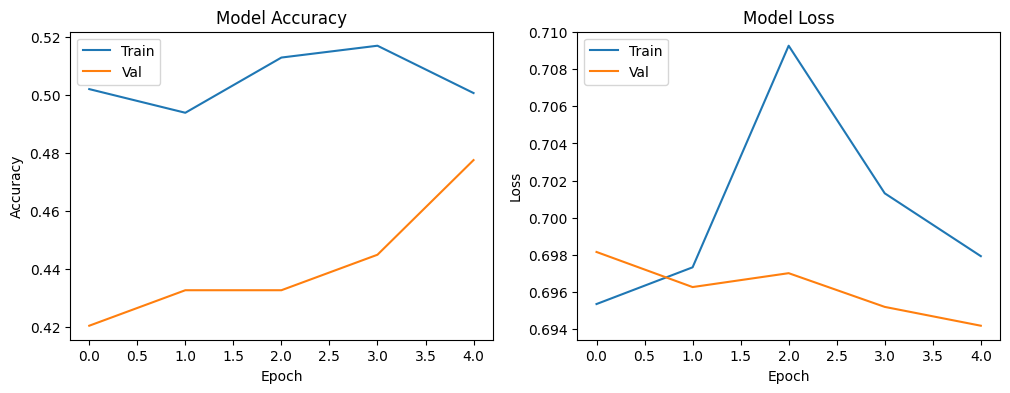

In [79]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_lstm.history['accuracy'])
axes[0].plot(history_lstm.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Val'], loc='upper left')

# Plot the second graph on the right axis
axes[1].plot(history_lstm.history['loss'])
axes[1].plot(history_lstm.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Val'], loc='upper left')

# Display the plot
plt.show()

## Improve LSTM Models with Embedding Layer

### Subtask:
Introduce an `Embedding` layer as the first layer in all LSTM models (2-layer dropout 0.3, 2-layer dropout 0.7, 3-layer dropout 0.3, and 3-layer dropout 0.7) to convert integer sequences into dense vectors. Address the `UserWarning` by properly defining the input layer. Re-evaluate their performance.


Vocabulary size: 5000
Embedding dimension: 128
Input length: 35


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 35, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 35, 32)         │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 663,761 (2.53 MB)

 Trainable params: 663,761 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 378ms/step - accuracy: 0.4494 - loss: 0.6961 - val_accuracy: 0.4776 - val_loss: 0.6933
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.5042 - loss: 0.6935 - val_accuracy: 0.5184 - val_loss: 0.6931
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.5264 - loss: 0.6907 - val_accuracy: 0.5143 - val_loss: 0.6930
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.5140 - loss: 0.6938 - val_accuracy: 0.4939 - val_loss: 0.6931
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 323ms/step - accuracy: 0.5214 - loss: 0.6912 - val_accuracy: 0.4980 - val_loss: 0.6933
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step

Results of LSTM 2 layers with dropout 0.3 (with Embedding Layer)

              precision    recall  f1-score   support

           0       0.90      0.51      0.65       223
           1       0.08      0.41      0.13        22

    accuracy                           0.50       245
   macro avg       0.49      0.46      0

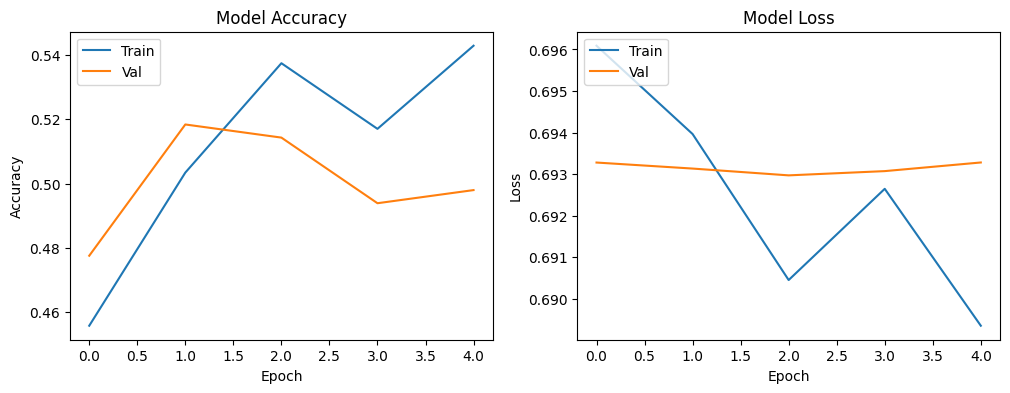

In [80]:
vocab_size = num_words
embedding_dim = 128
input_length = seq_maxlen

print(f"Vocabulary size: {vocab_size}")
print(f"Embedding dimension: {embedding_dim}")
print(f"Input length: {input_length}")

############################# LSTM: 2 layers with dropout 0.3 (with Embedding Layer) #############################

model_lstm_embed_2_03 = tf.keras.Sequential([
    tf.keras.Input(shape=(input_length,)), # Explicitly define input layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=input_length),
    tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(16, dropout=0.3, recurrent_dropout=0.2, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm_embed_2_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_embed_2_03.summary()

history_lstm_embed_2_03 = model_lstm_embed_2_03.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictionlstm_embed_2_03 = model_lstm_embed_2_03.predict(X_test)
y_prediction_lstm_embed_2_03 = [0 if val < 0.5 else 1 for val in test_predictionlstm_embed_2_03]

class_report_lstm_embed_2_03 = classification_report(y_prediction_lstm_embed_2_03, y_test)
conf_matrix_lstm_embed_2_03 = confusion_matrix(y_prediction_lstm_embed_2_03 , y_test)

print('\nResults of LSTM 2 layers with dropout 0.3 (with Embedding Layer)\n')
print(class_report_lstm_embed_2_03)
print(conf_matrix_lstm_embed_2_03)

# Calculate accuracy, precision, recall, f1-score
accuracy_lstm_embed_2_03 = accuracy_score(y_test, y_prediction_lstm_embed_2_03)
precision_lstm_embed_2_03 = precision_score(y_test, y_prediction_lstm_embed_2_03)
recall_lstm_embed_2_03 = recall_score(y_test, y_prediction_lstm_embed_2_03)
f_score_lstm_embed_2_03 = f1_score(y_test, y_prediction_lstm_embed_2_03)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy_lstm_embed_2_03, "     |\t", "Precision:", precision_lstm_embed_2_03, "     |\t", "Recall:", recall_lstm_embed_2_03, "    |\t",
      "F-score:", f_score_lstm_embed_2_03, "\n")

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(history_lstm_embed_2_03.history['accuracy'])
axes[0].plot(history_lstm_embed_2_03.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Val'], loc='upper left')
axes[1].plot(history_lstm_embed_2_03.history['loss'])
axes[1].plot(history_lstm_embed_2_03.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Val'], loc='upper left')
plt.show()

**Reasoning**:
I will implement the 2-layer LSTM model with an embedding layer and 0.7 dropout, compiling and training it, then evaluating its performance with classification metrics and plotting the training history.



#BiLSTM

#2 layers with dropout 0.3

In [88]:
max_len = 35
model_bilstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True),input_shape=(max_len, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, dropout=0.3, recurrent_dropout=0.2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()

history_bilstm = model_bilstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictionbilstm = model_bilstm.predict( X_test )
y_prediction = [0 if val < 0.5 else 1 for val in test_predictionbilstm]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  BILSTM \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 35, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,105 (74.63 KB)

 Trainable params: 19,105 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 494ms/step - accuracy: 0.4773 - loss: 0.7094 - val_accuracy: 0.5020 - val_loss: 0.6924
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 477ms/step - accuracy: 0.4876 - loss: 0.7030 - val_accuracy: 0.5429 - val_loss: 0.6895
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 0.5106 - loss: 0.6905 - val_accuracy: 0.5102 - val_loss: 0.6925
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 477ms/step - accuracy: 0.4586 - loss: 0.7060 - val_accuracy: 0.5020 - val_loss: 0.6920
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step - accuracy: 0.4841 - loss: 0.6999 - val_accuracy: 0.4898 - val_loss: 0.6929
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step
Results of  BILSTM 

              precision    recall  f1-score   support

           0       0.03      0.57      0.06         7
           1       0.97      0.49      0.65       238

    accuracy                           0.49       245
   macro avg       0.50      0.53      0.36       245
weighted avg       0.95      0.4

In [89]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.4897959183673469      |	 Precision: 0.48739495798319327      |	 Recall: 0.9747899159663865     |	 F-score: 0.6498599439775911 



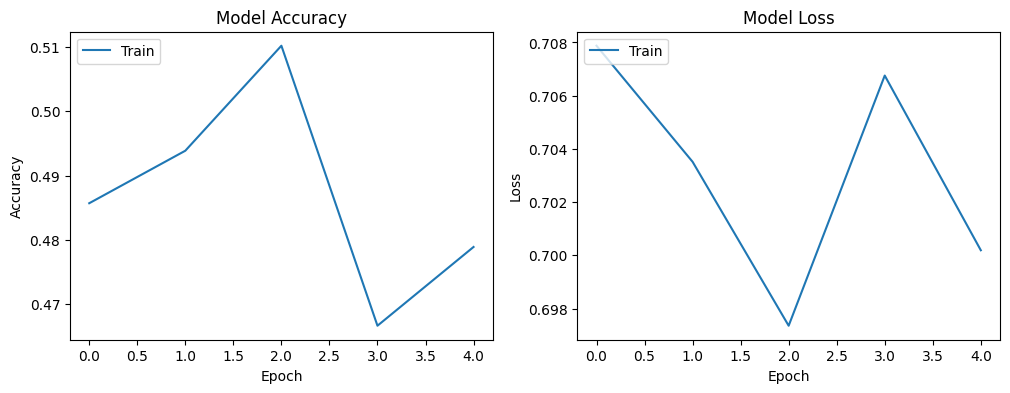

In [90]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_bilstm.history['accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot the second graph on the right axis
axes[1].plot(history_bilstm.history['loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Test'], loc='upper left')

# Display the plot
plt.show()

# 2 layers with dropout 0.7

In [91]:
max_len = 35
model_bilstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.7, recurrent_dropout=0.2, return_sequences=True),input_shape=(max_len, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, dropout=0.7, recurrent_dropout=0.2)),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()

history_bilstm = model_bilstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictionbilstm = model_bilstm.predict( X_test )
y_prediction = [0 if val < 0.5 else 1 for val in test_predictionbilstm]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  BILSTM \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 35, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,105 (74.63 KB)

 Trainable params: 19,105 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 924ms/step - accuracy: 0.4849 - loss: 0.7171 - val_accuracy: 0.5143 - val_loss: 0.7046
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 814ms/step - accuracy: 0.4730 - loss: 0.7271 - val_accuracy: 0.5143 - val_loss: 0.7018
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step - accuracy: 0.4806 - loss: 0.7128 - val_accuracy: 0.5143 - val_loss: 0.7005
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 869ms/step - accuracy: 0.4555 - loss: 0.7037 - val_accuracy: 0.5143 - val_loss: 0.6945
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 791ms/step - accuracy: 0.5087 - loss: 0.7103 - val_accuracy: 0.5143 - val_loss: 0.6946
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step
Results of  BILSTM 

              precision    recall  f1-score   support

           0       1.00      0.51      0.68       245
           1       0.00      0.00      0.00         0

    accuracy                           0.51       245
   macro avg       0.50      0.26      0.34       245
weighted avg       1.00      0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [92]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5142857142857142      |	 Precision: 0.0      |	 Recall: 0.0     |	 F-score: 0.0 



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


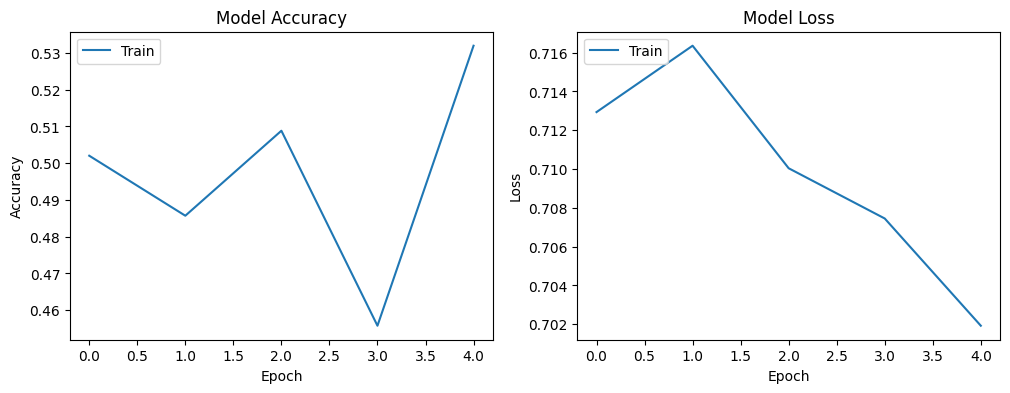

In [93]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_bilstm.history['accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot the second graph on the right axis
axes[1].plot(history_bilstm.history['loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Test'], loc='upper left')

# Display the plot
plt.show()


# 3 layers with dropout 0.3

In [94]:
max_len = 35
model_bilstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True),input_shape=(max_len, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, dropout=0.3, recurrent_dropout=0.2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()

history_bilstm = model_bilstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictionbilstm = model_bilstm.predict( X_test )
y_prediction = [0 if val < 0.5 else 1 for val in test_predictionbilstm]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  BILSTM \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 35, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 35, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,937 (171.63 KB)

 Trainable params: 43,937 (171.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 857ms/step - accuracy: 0.4946 - loss: 0.6977 - val_accuracy: 0.5184 - val_loss: 0.6917
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 570ms/step - accuracy: 0.4770 - loss: 0.7023 - val_accuracy: 0.4857 - val_loss: 0.6988
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 600ms/step - accuracy: 0.5130 - loss: 0.6965 - val_accuracy: 0.4653 - val_loss: 0.6951
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 688ms/step - accuracy: 0.4616 - loss: 0.6988 - val_accuracy: 0.5265 - val_loss: 0.6929
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 653ms/step - accuracy: 0.5449 - loss: 0.6878 - val_accuracy: 0.5265 - val_loss: 0.6932
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 535ms/step
Results of  BILSTM 

              precision    recall  f1-score   support

           0       0.99      0.52      0.68       240
           1       0.03      0.80      0.06         5

    accuracy                           0.53       245
   macro avg       0.51      0.66      0.37       245
weighted avg       0.97      0

In [95]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5265306122448979      |	 Precision: 0.8      |	 Recall: 0.03361344537815126     |	 F-score: 0.06451612903225806 



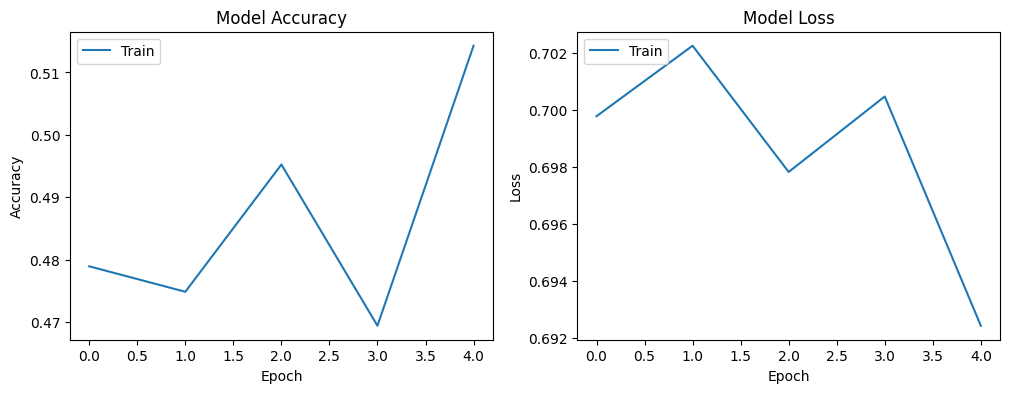

In [96]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_bilstm.history['accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot the second graph on the right axis
axes[1].plot(history_bilstm.history['loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Test'], loc='upper left')

# Display the plot
plt.show()

# 3 layers with dropout 0.7

In [97]:
max_len = 35
model_bilstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.7, recurrent_dropout=0.2, return_sequences=True),input_shape=(max_len, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.7, recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, dropout=0.7, recurrent_dropout=0.2)),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()

history_bilstm = model_bilstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

test_predictionbilstm = model_bilstm.predict( X_test )
y_prediction = [0 if val < 0.5 else 1 for val in test_predictionbilstm]

class_report = classification_report(y_prediction, y_test)
conf_matrix = confusion_matrix(y_prediction , y_test)

print('Results of  BILSTM \n')
print(class_report)
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional) │ (None, 35, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 35, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,937 (171.63 KB)

 Trainable params: 43,937 (171.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 884ms/step - accuracy: 0.5137 - loss: 0.7082 - val_accuracy: 0.5143 - val_loss: 0.6923
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 646ms/step - accuracy: 0.5223 - loss: 0.7151 - val_accuracy: 0.5143 - val_loss: 0.6915
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 606ms/step - accuracy: 0.4918 - loss: 0.7046 - val_accuracy: 0.5143 - val_loss: 0.6910
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 756ms/step - accuracy: 0.4963 - loss: 0.7176 - val_accuracy: 0.5143 - val_loss: 0.6909
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 640ms/step - accuracy: 0.4921 - loss: 0.7070 - val_accuracy: 0.5143 - val_loss: 0.6909
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step
Results of  BILSTM 

              precision    recall  f1-score   support

           0       1.00      0.51      0.68       245
           1       0.00      0.00      0.00         0

    accuracy                           0.51       245
   macro avg       0.50      0.26      0.34       245
weighted avg       1.00      0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [98]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
# Calculate precision
precision = precision_score(y_test, y_prediction)
# Calculate recall
recall = recall_score(y_test, y_prediction)
# Calculate F-score
f_score = f1_score(y_test, y_prediction)

print("\n\t\t\t\t\t\t\tEVALUATION MEASURES RESULTS")
print("\t\t\t\t\t\t", "_" * 40)
print("\nAccuracy:", accuracy, "     |\t", "Precision:", precision, "     |\t", "Recall:", recall, "    |\t",
      "F-score:", f_score, "\n")


							EVALUATION MEASURES RESULTS
						 ________________________________________

Accuracy: 0.5142857142857142      |	 Precision: 0.0      |	 Recall: 0.0     |	 F-score: 0.0 



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


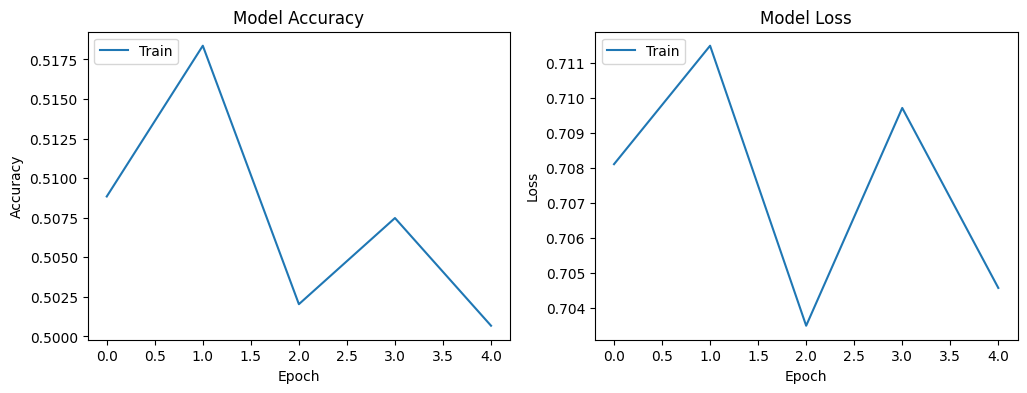

In [99]:
# Define the figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on the left axis
axes[0].plot(history_bilstm.history['accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'], loc='upper left')

# Plot the second graph on the right axis
axes[1].plot(history_bilstm.history['loss'])
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Test'], loc='upper left')

# Display the plot
plt.show()